# Relative peripheral refraction: a predictor for myopia progression - ray tracing simulation example

This example contains raytracing simulations for the paper [*A Novel MRI-Based Approach to Peripheral Refraction and Prediction of Myopia Progression*](https://doi.org/10.1016/j.ajo.2025.06.013).

## Citation

Next to citing ZOSPy, please also cite the following paper when using this example or the data provided within this example:

> Kneepkens SCM, Van Vught L, Polling JR, Klaver CCW, Tideman JWL, Beenakker JM. A Novel MRI-Based Approach to Peripheral Refraction and Prediction of Myopia Progression. Am J Ophthalmol. 2025 Oct;278:239-249. doi: 10.1016/j.ajo.2025.06.013.

## Warranty and liability

The presented code and data are made available for research purposes only. There is no warranty and rights can not be derived from them, as indicated in the general license of this repository.

## Import dependencies

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from helpers import zernike_coefficients_vs_field

import zospy as zp

## Initialize OpticStudio

Establishing a connection with OpticStudio through the [ZOSPy](https://joss.theoj.org/papers/10.21105/joss.05756) library. The code used for the scientific publication was based on [ZOSPy version 1.1.2](https://github.com/MREYE-LUMC/ZOSPy/releases/tag/v1.1.2). 

In  this example we connect with OpticStudio in `extension` mode. For more extensive simulations we advise to use the `standalone` for a significant increase in computation performace.

In [2]:
zos = zp.ZOS()

In [3]:
oss = zos.connect("extension")

## Define the eye model

The eye model used within this example is based on clinical measurements of the right eye of a healthy subject. Note that the abbreviation _roc_ stands for radius of curvature.

In [4]:
geometry = {
    "axial_length": 23.1,  # mm
    "cornea_thickness": 0.57,  # mm
    "cornea_front_roc_x": 7.83,  # mm
    "cornea_front_roc_x_axis": 1.5,  # degrees
    "cornea_front_roc_y": 7.70,  # mm
    "cornea_front_asphericity": -0.346,
    "cornea_back_roc_x": 6.34,  # mm
    "cornea_back_roc_y": 6.24,  # mm
    "cornea_back_asphericity": 0.0,
    "anterior_chamber_depth": 3.05,  # 3.05,  # mm, internal
    "pupil_radius": 1.5,  # mm
    "lens_thickness": 3.43,  # mm
    "lens_front_roc": 11.45,  # mm
    "lens_front_asphericity": 4.6e-4,
    "lens_back_roc": -6.24,  # mm
    "lens_back_asphericity": 2.49e-4,
    "retina_roc_x": -13.7,  # mm
    "retina_asphericity_x": 0.31,
    "retina_roc_y": -13.46,  # mm
    "retina_asphericity_y": 0.29,
}

refractive_indices = {  # at 589.3 nm (green light)
    "cornea": 1.376,
    "aqueous": 1.3374,
    "lens": 1.427,
    "vitreous": 1.336,
}

measured_refraction = {
    "Sphere": 0.5,  # Diopter
    "Cylinder": -0.5,  # Diopter
    "Axis": 101,  # degrees
}

### Initialize the optical system in OpticStudio
* The system is defined in sequential mode.
* For ray tracing, a wavelength of 589.3 nm is used.
* The aperture type is set to `FloatByStopSize`
* Ray aiming is set to `Real`.

In [5]:
WAVELENGTH = 589.3  # nm

In [6]:
oss.new()
oss.make_sequential()
oss.SystemData.Wavelengths.GetWavelength(1).Wavelength = WAVELENGTH / 1000
oss.SystemData.Aperture.ApertureType = zp.constants.SystemData.ZemaxApertureType.FloatByStopSize
oss.SystemData.RayAiming.RayAiming = zp.constants.SystemData.RayAimingMethod.Real

### Create the eye model

For each of the surfaces the curvature, asphericity, thickness and refractive index is set.

In [7]:
# Object
raytracing_object = oss.LDE.GetSurfaceAt(0)
raytracing_object.Comment = "Object"

# Input beam
input_beam = oss.LDE.InsertNewSurfaceAt(1)
input_beam.Comment = "Input beam"
input_beam.Thickness = 10
input_beam.DrawData.DoNotDrawThisSurface = True

# Cornea front
cornea_front = oss.LDE.InsertNewSurfaceAt(2)
zp.functions.lde.surface_change_type(cornea_front, zp.constants.Editors.LDE.SurfaceType.Biconic)  # Change to biconic
cornea_front.Comment = "Cornea Front"
cornea_front.Thickness = geometry["cornea_thickness"]
cornea_front.Radius = geometry["cornea_front_roc_y"]
cornea_front.Conic = geometry["cornea_front_asphericity"]
cornea_front.GetCellAt(12).DoubleValue = geometry["cornea_front_roc_x"]  # radius 2
cornea_front.GetCellAt(13).DoubleValue = geometry["cornea_front_asphericity"]  # conic 2
zp.solvers.material_model(cornea_front.MaterialCell, refractive_index=refractive_indices["cornea"])
cornea_front.SemiDiameter = 6
cornea_front.MechanicalSemiDiameter = 6

# Rotate the surface to ensure the a correct axis for the corneal curvatures
cornea_front.TiltDecenterData.BeforeSurfaceTiltZ = geometry["cornea_front_roc_x_axis"]
cornea_front.TiltDecenterData.SetAfterSurfaceModeReverseThis()

# Cornea back
cornea_back = oss.LDE.InsertNewSurfaceAt(3)
zp.functions.lde.surface_change_type(cornea_back, zp.constants.Editors.LDE.SurfaceType.Biconic)  # Change to biconic
cornea_back.Comment = "Cornea Back"
cornea_back.Thickness = geometry["anterior_chamber_depth"]
cornea_back.Radius = geometry["cornea_back_roc_y"]
cornea_back.Conic = geometry["cornea_back_asphericity"]
cornea_back.GetCellAt(12).DoubleValue = geometry["cornea_back_roc_x"]  # radius 2
cornea_back.GetCellAt(13).DoubleValue = geometry["cornea_back_asphericity"]  # conic 2
zp.solvers.material_model(cornea_back.MaterialCell, refractive_index=refractive_indices["aqueous"])
cornea_back.SemiDiameter = 5
cornea_back.MechanicalSemiDiameter = 5

cornea_back.DrawData.DoNotDrawEdgesFromThisSurface = True

# Pupil
pupil = oss.LDE.GetSurfaceAt(4)
assert pupil.IsStop, "Pupil must be the STOP surface."
pupil.Comment = "Pupil"
pupil.SemiDiameter = geometry["pupil_radius"]
pupil.MechanicalSemiDiameter = 6
zp.solvers.material_model(pupil.MaterialCell, refractive_index=refractive_indices["aqueous"])
pupil.DrawData.DoNotDrawEdgesFromThisSurface = True

# Lens front
lens_front = oss.LDE.InsertNewSurfaceAt(5)
lens_front.Comment = "Lens Front"
lens_front.Thickness = geometry["lens_thickness"]
lens_front.Radius = geometry["lens_front_roc"]
lens_front.Conic = geometry["lens_front_asphericity"]
lens_front.SemiDiameter = 4.25
lens_front.MechanicalSemiDiameter = 4.25
zp.solvers.material_model(lens_front.MaterialCell, refractive_index=refractive_indices["lens"])

# Coordinate break 1
coordinate_break_1 = oss.LDE.InsertNewSurfaceAt(6)
coordinate_break_1.Comment = "Coordinate Break 1"
zp.functions.lde.surface_change_type(coordinate_break_1, zp.constants.Editors.LDE.SurfaceType.CoordinateBreak)

# Lens back
lens_back = oss.LDE.InsertNewSurfaceAt(7)
zp.functions.lde.surface_change_type(lens_back, zp.constants.Editors.LDE.SurfaceType.Biconic)
lens_back.Comment = "Lens Back"
zp.solvers.position(lens_back.ThicknessCell, cornea_front.RowIndex, geometry["axial_length"])
lens_back.Radius = geometry["lens_back_roc"]
lens_back.Conic = geometry["lens_back_asphericity"]
lens_back.GetCellAt(12).DoubleValue = geometry["lens_back_roc"]  # radius 2
lens_back.GetCellAt(13).DoubleValue = geometry["lens_back_asphericity"]  # conic 2
lens_back.SemiDiameter = 4.25
lens_back.MechanicalSemiDiameter = 4.25
zp.solvers.material_model(lens_back.MaterialCell, refractive_index=refractive_indices["vitreous"])
lens_back.DrawData.DoNotDrawEdgesFromThisSurface = True

# Coordbreak 2
coordinate_break_2 = oss.LDE.InsertNewSurfaceAt(8)
coordinate_break_2.Comment = "CoordBreak2"
zp.functions.lde.surface_change_type(coordinate_break_2, zp.constants.Editors.LDE.SurfaceType.CoordinateBreak)
coordinate_break_2.TiltDecenterData.CoordinateReturn = zp.constants.Editors.LDE.CoordinateReturnType.OrientationXY
coordinate_break_2.TiltDecenterData.CoordinateReturnToSurface = raytracing_object.SurfaceNumber

# Retina
retina = oss.LDE.GetSurfaceAt(9)
retina.Comment = "Retina"
zp.functions.lde.surface_change_type(retina, zp.constants.Editors.LDE.SurfaceType.Biconic)
retina.Radius = geometry["retina_roc_y"]
retina.Conic = geometry["retina_asphericity_y"]
retina.GetCellAt(12).DoubleValue = geometry["retina_roc_x"]
retina.GetCellAt(13).DoubleValue = geometry["retina_asphericity_x"]
retina.SemiDiameter = 12

zp.solvers.material_model(retina.MaterialCell, refractive_index=refractive_indices["vitreous"])

# Set fields
To use the Zernike vs Field analysis, we ensure 4 additional fields are set at a maximum of 55 degrees in every principal meridian.

In [8]:
# Fields
field1 = oss.SystemData.Fields.GetField(1)

# Add fields
max_field = 55
field2 = oss.SystemData.Fields.AddField(0, max_field, 1)  # +y
field3 = oss.SystemData.Fields.AddField(0, -max_field, 1)  # -y
field4 = oss.SystemData.Fields.AddField(max_field, 0, 1)  # +x
field5 = oss.SystemData.Fields.AddField(-max_field, 0, -1)  # -x

# Determine lens curvature to match central refraction

We determine lens curvature such that the central refraction of the optical system matches the clinically measured refraction. To that end, we first convert the clinically measured refraction into Zernike coefficients, and then set those coefficients as target in a merit function. The merit funcion is used to iteratively alter the lens thickness, lens back geometry and lens back tilt such that the eye model matches the measured central refraction. As the tilt of a surface cannot be directly altered in the merit function, the coordinate breaks are used to alter the tilt. Finally, the merit function has some restraints to maintain a proper lens shape.

> <details>
> <summary>Merit function details</summary>
>  
> The merit function consist of several components. All components have a weight of either 1 or 0. Operands with a weight of 1 are being taken into account for the optimization. Operands with a weight of 0 are not directly taken into accound (but e.g. used within other operands). The used operands include:
> * 3 ZERN operands _(Weights=1)_ used to optimize $Z4$, $Z5$ and $Z6$ such that the eye model matches the refraction. 
> * 1 ZERN operand _(Weight=0)_ that is used to set the maximal Zernike term used in Zernike calculations to 15.
> * PMGT and PMLT operands _(Weights=1)_ to set limitations of -45 and 45 degrees for the tilt of the back of the lens. 
> * 2x a combination of two ETVA _(Weights=0)_, one SUMM _(Weight=0)_ and one OPGT _(Weight=1)_ operand to ensure that the outer edges of the anterior and posterior lens surface are at least separated by 0.1 mm in both +x and +y
> * CTGT and CTLT operands _(Weight=1)_ to allow the center thickness of the lens to increase or decrease maximally 0.2 mm.
> * A combination of COVA  _(Weight=0)_, OPGT _(Weight=1)_, and  OPLT _(Weight=1)_ operands to set constraints on the conic value of the back of the lens.
> * A bombination of PMGT and PMLT operands _(Weights=1)_ to apply those same conic constaints on the second comic parameter of the back of the lens (given its a biconic surface).
>
> For brevity, the merit function is loaded rather than constructed using `ZOSPy`. Below is an example of how to construct them using `ZOSPy`.
>
>
> ```python
> oss.MFE.ShowEditor()  # For visualization of the MFE, can be omitted
> oss.MFE.DeleteAllRows()  # Clean the MFE 
> op1 = oss.MFE.GetOperandAt(1)  # The MFE has one empty operand after DeleteAllRows(). 
> op1.ChangeType(zp.constants.Editors.MFE.MeritOperandType.ZERN)
> op1.GetOperandCell(zp.constants.Editors.MFE.MeritColumn.Param1).IntegerValue = 4
> op1.GetOperandCell(zp.constants.Editors.MFE.MeritColumn.Param3).IntegerValue = int(zp.constants.Analysis.SampleSizes.S_512x512)
> op1.GetOperandCell(zp.constants.Editors.MFE.MeritColumn.Param5).IntegerValue = 1
> op1.Target = 0 # The target, later set to z4_target
> op1.Weight = 1
>
> # Additional arguments can be added using oss.MFE.AddOperand()
> ```
> </details>

To work with this merit function, pupil data from the current model is required

In [9]:
pupil_data = zp.functions.lde.get_pupil(oss)
exit_pupil_diameter = pupil_data.ExitPupilDiameter
exit_pupil_radius = exit_pupil_diameter / 2

Then use that to calculate the target Zernike values

In [10]:
# Calculate power vectors M, J0 and J45
m_measured = measured_refraction["Sphere"] + measured_refraction["Cylinder"] / 2
j_measured = -measured_refraction["Cylinder"] / 2
j0_measured = j_measured * np.cos(2 * np.deg2rad(measured_refraction["Axis"]))
j45_measured = j_measured * np.sin(2 * np.deg2rad(measured_refraction["Axis"]))

z4_target = ((exit_pupil_radius**2 * m_measured) / (4 * np.sqrt(3) * -1)) / (WAVELENGTH / 1000)
z6_target = ((exit_pupil_radius**2 * j0_measured) / (2 * np.sqrt(6) * -1)) / (WAVELENGTH / 1000)
z5_target = ((exit_pupil_radius**2 * j45_measured) / (2 * np.sqrt(6) * -1)) / (WAVELENGTH / 1000)

Then set the targets for the mertit optimizer

In [11]:
zp.solvers.variable(lens_front.ThicknessCell)  # Lens thickness
zp.solvers.variable(coordinate_break_1.GetCellAt(16))  # Rotation of lens back
zp.solvers.variable(lens_back.RadiusCell)  # Radius y
zp.solvers.variable(lens_back.ConicCell)  # Conic y
zp.solvers.variable(lens_back.GetCellAt(12))  # Radius x
zp.solvers.variable(lens_back.GetCellAt(13))  # Conic X

Load the merit function, set targets and optimize

In [ ]:
oss.MFE.ShowEditor()
oss.MFE.LoadMeritFunction(str(Path("ExampleMeritFunction.MF").absolute()))

# Set targets
op1 = oss.MFE.GetOperandAt(1)
op1.Target = z4_target
op2 = oss.MFE.GetOperandAt(2)
op2.Target = z6_target
op3 = oss.MFE.GetOperandAt(3)
op3.Target = z5_target

In [13]:
# Optimze
local_optimization = oss.Tools.OpenLocalOptimization()
local_optimization.Algorithm = zp.constants.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
local_optimization.Cycles = zp.constants.Tools.Optimization.OptimizationCycles.Automatic
local_optimization.NumberOfCores = 8
local_optimization.RunAndWaitForCompletion()
local_optimization.Close()

True

Optimization result

In [14]:
pd.DataFrame(
    columns=["Target", "Result"],
    index=["Z4", "Z5", "Z6"],
    data=[[op1.Target, op1.Value], [op2.Target, op2.Value], [op3.Target, op3.Value]],
)

,Target,Result
Z4,-0.147964,-0.147964
Z5,0.194016,0.194016
Z6,0.078388,0.078388


# Show model

In [15]:
zp.analyses.systemviewers.viewer_3d(oss)

'AnalysisType': 'Draw3D'
'Data': None
'HeaderData': []
'Messages': []
'MetaData': AnalysisMetadata(DateTime=datetime.datetime(2025, 1, 25, 17, 0, 32, 788000), FeatureDescription='', LensFile='D:\\Software\\OpticStudio\\SAMPLES\\LENS.ZMX', LensTitle='')
'Settings': None

![The final eye model](example_eye_model.jpg)

# Calculate peripheral refraction

First recalculate the pupil data as the system has changed.

In [16]:
pupil_data = zp.functions.lde.get_pupil(oss)
exit_pupil_diameter = pupil_data.ExitPupilDiameter
exit_pupil_radius = exit_pupil_diameter / 2


Then calculate the peripheral refraction using the Zernike vs. Fields analysis

In [17]:
zc_minx = zernike_coefficients_vs_field(
    oss, coefficients="1-15", coefficients_type="Standard", field_scan="-x", field_density=11, sampling="512x512"
)
zc_plusx = zernike_coefficients_vs_field(
    oss, coefficients="1-15", coefficients_type="Standard", field_scan="+x", field_density=11, sampling="512x512"
)
zc_miny = zernike_coefficients_vs_field(
    oss, coefficients="1-15", coefficients_type="Standard", field_scan="-y", field_density=11, sampling="512x512"
)
zc_plusy = zernike_coefficients_vs_field(
    oss, coefficients="1-15", coefficients_type="Standard", field_scan="+y", field_density=11, sampling="512x512"
)

# Change the index for negative values as they come out as positive
zc_minx.Data.ZernikeVsField.index = zc_minx.Data.ZernikeVsField.index * -1
zc_miny.Data.ZernikeVsField.index = zc_miny.Data.ZernikeVsField.index * -1

# Combine into one dataframe
zrn_vs_field = pd.concat(
    [
        zc_plusx.Data.ZernikeVsField,
        zc_minx.Data.ZernikeVsField,
        zc_plusy.Data.ZernikeVsField,
        zc_miny.Data.ZernikeVsField,
    ],
    keys=["+x", "-x", "+y", "-y"],
)

# Calculate Spherical equivalent using Z4
spherical_equivalent = (-zrn_vs_field.loc[:, 4] * (WAVELENGTH / 1000) * 4 * np.sqrt(3)) / (exit_pupil_radius**2)

# Plot results

First create two variables, one for horizontal and one for vertical refraction

In [18]:
horizontal_refraction = spherical_equivalent.loc[["+x", "-x"]].drop(("-x", 0))
horizontal_refraction = horizontal_refraction.droplevel(0).sort_index()

vertical_refraction = spherical_equivalent.loc[["+y", "-y"]].drop(("-y", 0))
vertical_refraction = vertical_refraction.droplevel(0).sort_index()

Then plot them

Text(0.5, 0, 'Eccentricity (degrees)')

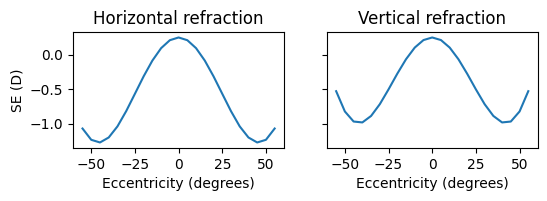

In [19]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 1.5))
ax[0].plot(horizontal_refraction)
ax[0].set_title("Horizontal refraction")
ax[0].set_xlabel("Eccentricity (degrees)")
ax[0].set_ylabel("SE (D)")
ax[1].plot(vertical_refraction)
ax[1].set_title("Vertical refraction")
ax[1].set_xlabel("Eccentricity (degrees)")